Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co
jariasg@uniquindio.edu.co

#GIN - Graph Isomorphism Network

Implementaremos GIN-Convolucion, usando:
* Agregación Vecinal Principal (PNA)
* Funciones de agregación de aprendizaje (LAF)  

# Imports y utils

In [5]:
!pip install torch_geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


from torch_geometric.nn import MessagePassing, SAGEConv, GINConv, global_add_pool
import torch_scatter
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import os.path as osp

# Message Passing Class

Estamos interesados en el método agregado o, si está utilizando una matriz de adyacencia dispersa, en el método message_and_aggregate.

Las clases convolucionales en PyG extienden MessagePassing,.
construimos nuestra clase convocional personalizada que extiende GINConv.


Operación de dispersión en conjunto:


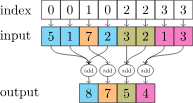

In [6]:
from torch_geometric.nn import MessagePassing
from torch.nn import Parameter, Module, Sigmoid
import torch
import torch_scatter
import torch.nn.functional as F

In [7]:
class AbstractLAFLayer(Module):
    def __init__(self, **kwargs):
        super(AbstractLAFLayer, self).__init__()
        assert 'units' in kwargs or 'weights' in kwargs
        if 'device' in kwargs.keys():
            self.device = kwargs['device']
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.ngpus = torch.cuda.device_count()

        if 'kernel_initializer' in kwargs.keys():
            assert kwargs['kernel_initializer'] in [
                'random_normal',
                'glorot_normal',
                'he_normal',
                'random_uniform',
                'glorot_uniform',
                'he_uniform']
            self.kernel_initializer = kwargs['kernel_initializer']
        else:
            self.kernel_initializer = 'random_normal'

        if 'weights' in kwargs.keys():
            self.weights = Parameter(kwargs['weights'].to(self.device), \
                                     requires_grad=True)
            self.units = self.weights.shape[1]
        else:
            self.units = kwargs['units']
            params = torch.empty(12, self.units, device=self.device)
            if self.kernel_initializer == 'random_normal':
                torch.nn.init.normal_(params)
            elif self.kernel_initializer == 'glorot_normal':
                torch.nn.init.xavier_normal_(params)
            elif self.kernel_initializer == 'he_normal':
                torch.nn.init.kaiming_normal_(params)
            elif self.kernel_initializer == 'random_uniform':
                torch.nn.init.uniform_(params)
            elif self.kernel_initializer == 'glorot_uniform':
                torch.nn.init.xavier_uniform_(params)
            elif self.kernel_initializer == 'he_uniform':
                torch.nn.init.kaiming_uniform_(params)
            self.weights = Parameter(params, \
                                     requires_grad=True)
        e = torch.tensor([1,-1,1,-1], dtype=torch.float32, device=self.device)
        self.e = Parameter(e, requires_grad=False)
        num_idx = torch.tensor([1,1,0,0], dtype=torch.float32, device=self.device).\
                                view(1,1,-1,1)
        self.num_idx = Parameter(num_idx, requires_grad=False)
        den_idx = torch.tensor([0,0,1,1], dtype=torch.float32, device=self.device).\
                                view(1,1,-1,1)
        self.den_idx = Parameter(den_idx, requires_grad=False)

In [8]:
class LAFLayer(AbstractLAFLayer):
    def __init__(self, eps=1e-7, **kwargs):
        super(LAFLayer, self).__init__(**kwargs)
        self.eps = eps

    def forward(self, data, index, dim=0, **kwargs):
        eps = self.eps
        sup = 1.0 - eps
        e = self.e

        x = torch.clamp(data, eps, sup)
        x = torch.unsqueeze(x, -1)
        e = e.view(1,1,-1)

        exps = (1. - e)/2. + x*e
        exps = torch.unsqueeze(exps, -1)
        exps = torch.pow(exps, torch.relu(self.weights[0:4]))

        scatter = torch_scatter.scatter_add(exps, index.view(-1), dim=dim)
        scatter = torch.clamp(scatter, eps)

        sqrt = torch.pow(scatter, torch.relu(self.weights[4:8]))
        alpha_beta = self.weights[8:12].view(1,1,4,-1)
        terms = sqrt * alpha_beta

        num = torch.sum(terms * self.num_idx, dim=2)
        den = torch.sum(terms * self.den_idx, dim=2)

        multiplier = 2.0*torch.clamp(torch.sign(den), min=0.0) - 1.0

        den = torch.where((den < eps) & (den > -eps), multiplier*eps, den)

        res = num / den
        return res

#LAF Aggregations module

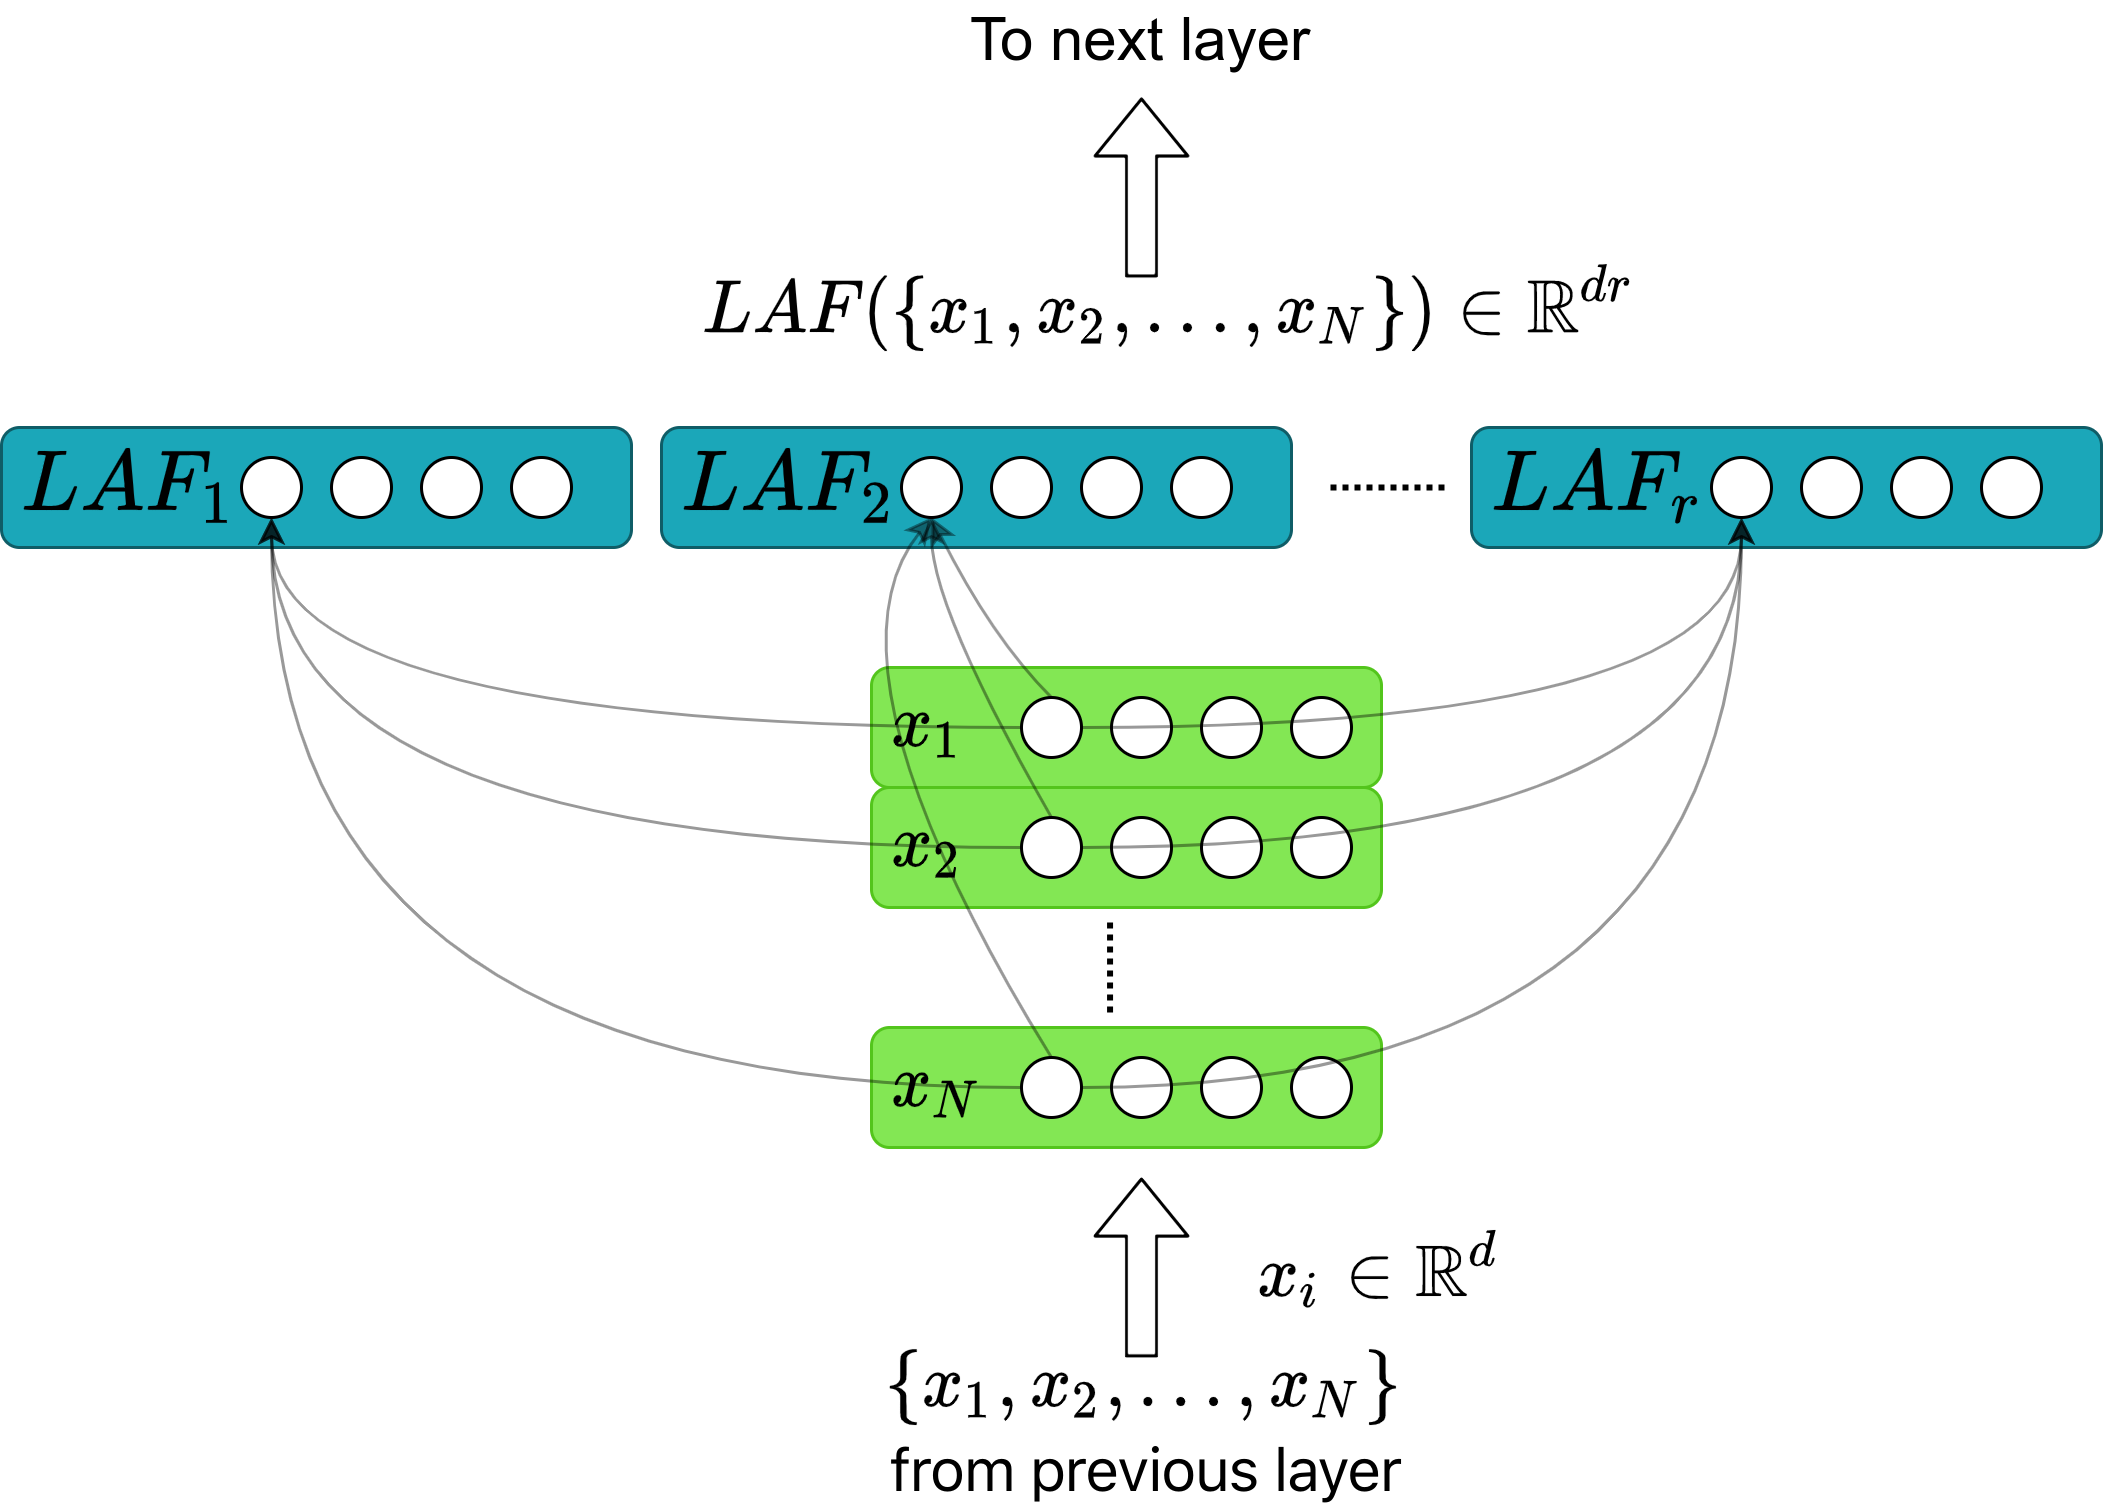

In [9]:
from torch_geometric.nn import GINConv
from torch.nn import Linear


class GINLAFConv(GINConv):
    def __init__(self, nn, units=1, node_dim=32, **kwargs):
        super(GINLAFConv, self).__init__(nn, **kwargs)
        self.laf = LAFLayer(units=units, kernel_initializer='random_uniform')
        self.mlp = torch.nn.Linear(node_dim*units, node_dim)
        self.dim = node_dim
        self.units = units

    def aggregate(self, inputs, index):
        x = torch.sigmoid(inputs)
        x = self.laf(x, index)
        x = x.view((-1, self.dim * self.units))
        x = self.mlp(x)
        return x


# PNA Aggregation

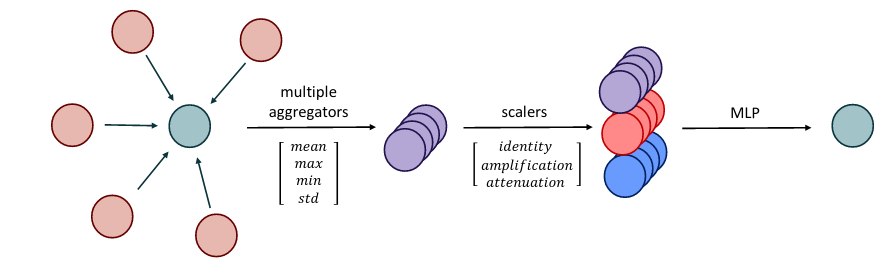

In [10]:
class GINPNAConv(GINConv):
    def __init__(self, nn, node_dim=32, **kwargs):
        super(GINPNAConv, self).__init__(nn, **kwargs)
        self.mlp = torch.nn.Linear(node_dim*12, node_dim)
        self.delta = 2.5749

    def aggregate(self, inputs, index):
        sums = torch_scatter.scatter_add(inputs, index, dim=0)
        maxs = torch_scatter.scatter_max(inputs, index, dim=0)[0]
        means = torch_scatter.scatter_mean(inputs, index, dim=0)
        var = torch.relu(torch_scatter.scatter_mean(inputs ** 2, index, dim=0) - means ** 2)

        aggrs = [sums, maxs, means, var]
        c_idx = index.bincount().float().view(-1, 1)
        l_idx = torch.log(c_idx + 1.)

        amplification_scaler = [c_idx / self.delta * a for a in aggrs]
        attenuation_scaler = [self.delta / c_idx * a for a in aggrs]
        combinations = torch.cat(aggrs+ amplification_scaler+ attenuation_scaler, dim=1)
        x = self.mlp(combinations)

        return x

#Nuevas clases

## MUTAG dataset

El conjunto de datos MUTAG es una colección de compuestos nitroaromáticos y el objetivo es predecir su mutagenicidad en Salmonella typhimurium.

In [12]:
path = osp.join('./', 'data', 'TU')
dataset = TUDataset(path, name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: MUTAG(188)
-------------------
Number of graphs: 188
Number of nodes: 21
Number of features: 7
Number of classes: 2


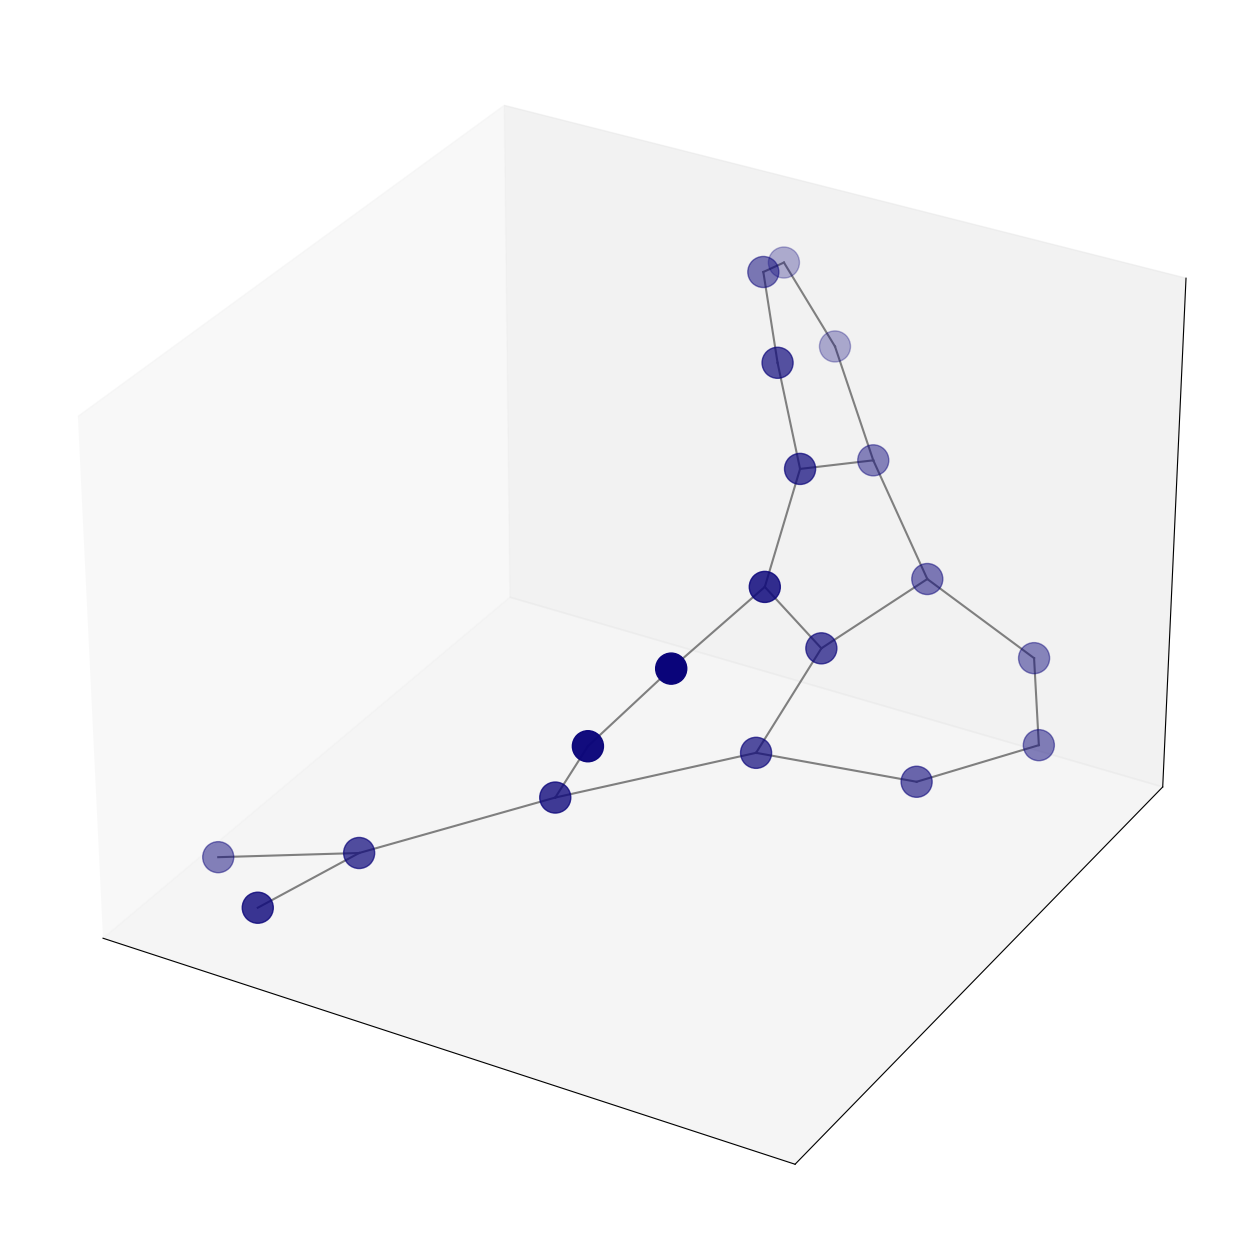

In [24]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[187], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

## Modelos
1. LAFNet
2. PNANet
3. GINNet


In [13]:
class LAFNet(torch.nn.Module):
    def __init__(self):
        super(LAFNet, self).__init__()

        num_features = dataset.num_features
        dim = 32
        units = 3

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINLAFConv(nn1, units=units, node_dim=num_features)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINLAFConv(nn2, units=units, node_dim=dim)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINLAFConv(nn3, units=units, node_dim=dim)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINLAFConv(nn4, units=units, node_dim=dim)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINLAFConv(nn5, units=units, node_dim=dim)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)


    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [14]:
class PNANet(torch.nn.Module):
    def __init__(self):
        super(PNANet, self).__init__()

        num_features = dataset.num_features
        dim = 32

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINPNAConv(nn1, node_dim=num_features)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINPNAConv(nn2, node_dim=dim)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINPNAConv(nn3, node_dim=dim)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINPNAConv(nn4, node_dim=dim)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINPNAConv(nn5, node_dim=dim)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)


    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [15]:
class GINNet(torch.nn.Module):
    def __init__(self):
        super(GINNet, self).__init__()

        num_features = dataset.num_features
        dim = 32

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

## Train - Test

In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = "PNA"

if net == "LAF":
    model = LAFNet().to(device)
elif net == "PNA":
    model = PNANet().to(device)
elif net == "GIN":
    GINNet().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


for epoch in range(1, 101):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
                                                       train_acc, test_acc))

Epoch: 001, Train Loss: 1.2466052, Train Acc: 0.2470588, Test Acc: 0.3333333
Epoch: 002, Train Loss: 0.8664009, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 003, Train Loss: 0.7480099, Train Acc: 0.2470588, Test Acc: 0.3333333
Epoch: 004, Train Loss: 0.5906197, Train Acc: 0.1647059, Test Acc: 0.1666667
Epoch: 005, Train Loss: 0.6384485, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 006, Train Loss: 0.4789500, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 007, Train Loss: 0.5236041, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 008, Train Loss: 0.5237248, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 009, Train Loss: 0.4981657, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 010, Train Loss: 0.3708826, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 011, Train Loss: 0.3887145, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 012, Train Loss: 0.3422501, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 013, Train Loss: 0.3936893, Train Acc: 0.6294118, Test Acc: 0.5555556

## Test Visualización

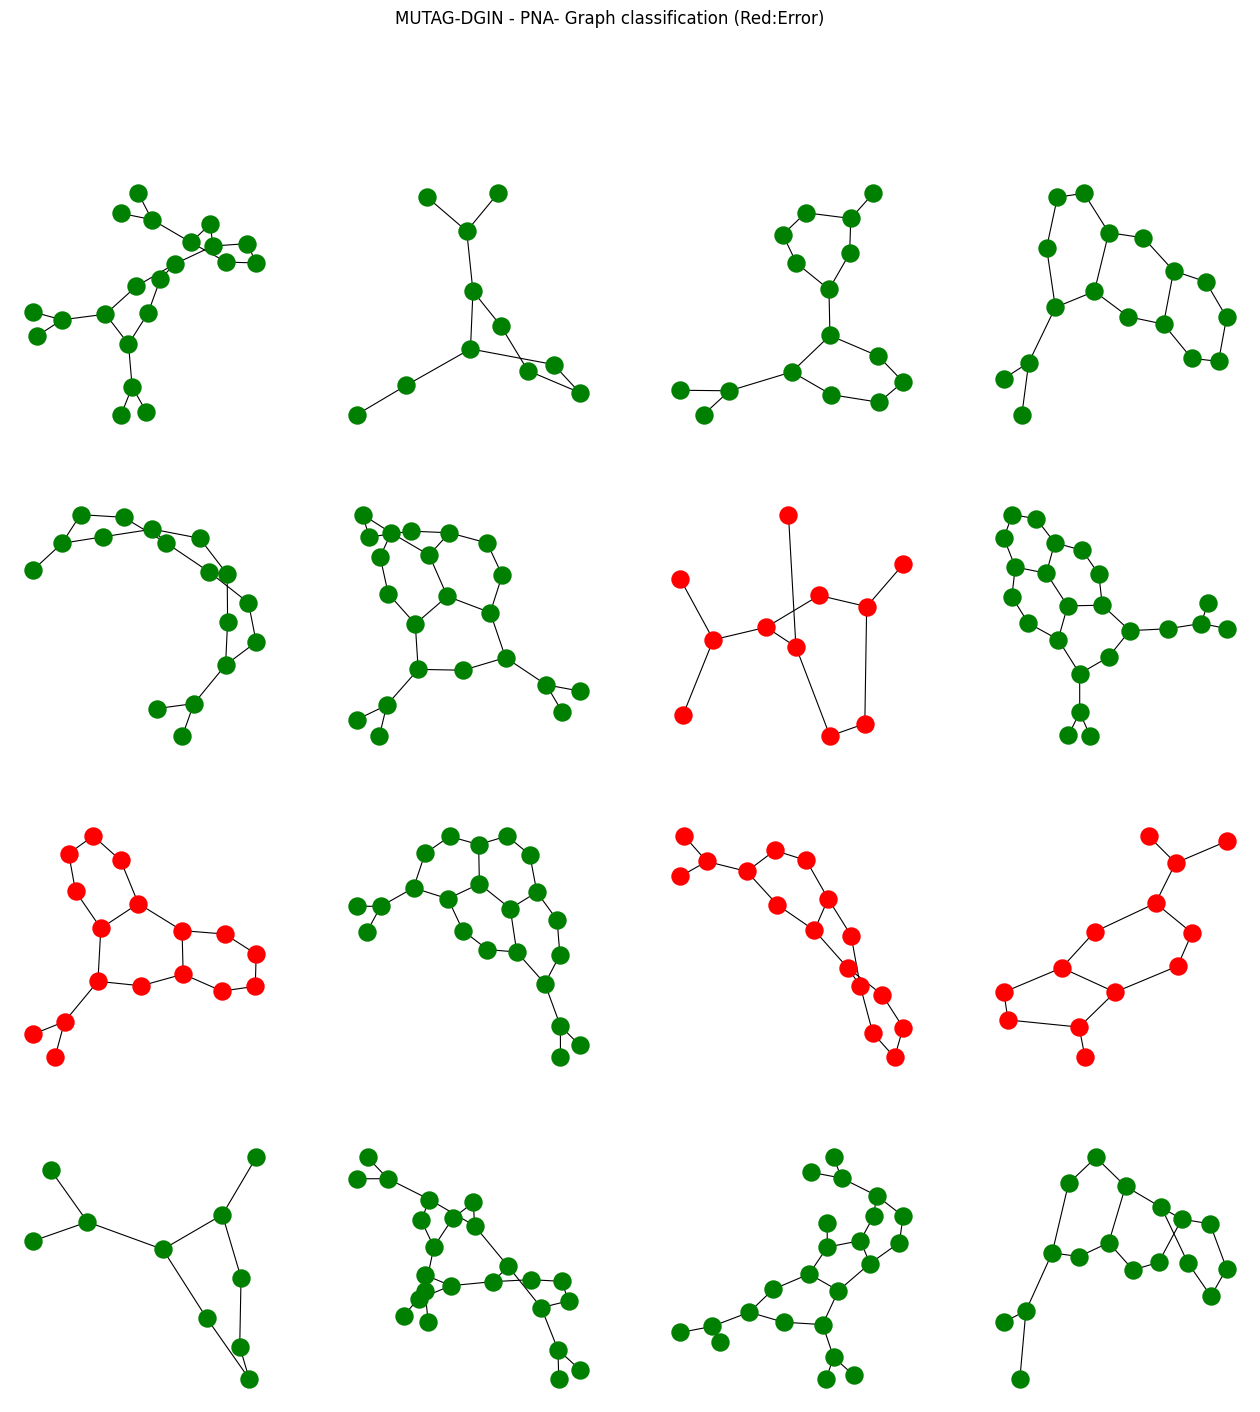

In [177]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle(f'MUTAG-DGIN - {net}- Graph classification (Red:Error)')
model.eval()

for i,data in enumerate(test_dataset[0-16:]):
    # Calculate color (green if correct, red otherwise)
    # _, out = output(data.x, data.edge_index, data.batch)
    out = model(data.x, data.edge_index, data.batch)
    pred = out.max(dim=1)[1]
    color_tensor = ['green' if pred == data.y else 'red']

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(test_dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color_tensor,
                    width=0.8,
                    ax=ax[ix]
                    )